In [1]:
%matplotlib inline

import sys
import os
sys.path.append("../../..")

import numpy as np
import re
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

## Get Rasters Informations, size, Geotransform... following one of the grid

In [2]:
ClassifFolder = '../../../Poe/Resultats/Classifications/'
ImagesFolder = '../../../Poe/Images/Acolyte/S2A_MSIL1C_20180305T230901_N0206_R101_T58KEB_20180306T00234_bisAco/S2A_MSI_2018_03_05_23_09_01_T58KEB_L2R_tif/'
raster_wavelength = ['560']
raster_Name = ['rhos_' + l + '.tif' for l in raster_wavelength]

src_ds = gdal.Open(ImagesFolder+raster_Name[0], gdal.GA_ReadOnly)
band = src_ds.GetRasterBand(1)
GT_ds = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
RasterHeight, RasterWidth = (src_ds.RasterYSize, src_ds.RasterXSize)
print(RasterHeight, RasterWidth)

10980 10980


## Define Rasters footprint

In [3]:
# Define Raster Footprint
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (164.99980652185837, -21.791778063706154) 
Lower right corner :  (166.0548316017674, -20.79645641405817)


## Get surveyfiles (ascii), having measurement contained in rasters footprint

In [4]:
FileWorkableSur = '../../Terrain/MesuresBathy/Poe_22and23_05_2018.txt'

MeasurementFrame = pd.read_csv(FileWorkableSur)
Lon = MeasurementFrame['Lon'].astype('float64').values
Lat = MeasurementFrame['Lat'].astype('float64').values

CoordinatesSet = np.stack([Lon,Lat], axis=1)
depth = MeasurementFrame['Depth'].astype('float32').values

del MeasurementFrame, Lon, Lat

##  Convert measurements coordinate in pixels coordinate (+ checking process)

In [5]:
testLocation = np.array([[166.0618842, -21.7883184],
                         [166.0618359, -21.7882778],
                         [166.0619313, -21.7882778],
                         [166.0619313, -21.7883652],
                         [166.0618326, -21.7883166]])

# Define pixel location of measured data
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)
(Cols, Rows) = mgp.GetPixel(ctInv, inv_geometrix, testLocation,integer=False)
Location = ['Center', 'UpperLeft', 'UpperRight', 'LowerRight','PreviousNext']
[print(Loc,'at Row:', row,', Col:', col) for Loc, col, row in zip(Location, Cols,Rows)]

# Project coordinates in pixel coordinates then filter measured data projected outside image extent
px, py = mgp.GetPixel(ctInv, inv_geometrix, CoordinatesSet,integer=False) # Case for dense field data, need interger=False for wheigtering or interpolation
indexOut = np.logical_or(np.logical_or(py>RasterHeight-1,py<0), np.logical_or(px>RasterWidth-1,px<0))
px, py = px[~indexOut], py[~indexOut]

# Adjust water depth following the Tide at the image sensor Time
TideHeight = 1.31 # Height of tide from SHOM website
depth = depth[~indexOut]+TideHeight

# filter measured data with negative depth (due to tide)
indexOut = depth<0
print('Number of point with negative depth :', np.sum(indexOut))
px, py, depth = px[~indexOut], py[~indexOut], depth[~indexOut]
assert px.shape==py.shape and px.shape == depth.shape

no int
Center at Row: 10979.4685216 , Col: 10979.5091234
UpperLeft at Row: 10979.0156563 , Col: 10979.0128596
UpperRight at Row: 10979.0224421 , Col: 10979.999165
LowerRight at Row: 10979.9899339 , Col: 10979.9925083
PreviousNext at Row: 10979.444926 , Col: 10978.9757872
no int
Number of point with negative depth : 0


## Get workingIndex or Index of classification and bathymetry mapping
###### In others words :        ClassifIndex = ~Soil x ~DeepOcean x CroppedImage
######                                     ClassifIndex.shape == Initial_Rasters.shape

(10980, 10980)


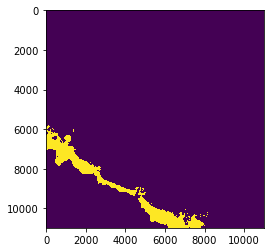

In [6]:
Lagoon = 'Mask/Lagoon.tif'

ClassifIndex = gdal.Open(ImagesFolder + Lagoon, gdal.GA_ReadOnly)
ClassifIndex = ClassifIndex.GetRasterBand(1).ReadAsArray().astype(bool)
print(ClassifIndex.shape)
plt.imshow(ClassifIndex)

## Create index(SurveyIndex) indicating the presence of measurements in a pixel
## Create dictionary(Dicto) of depths measured at a pixel location

In [7]:
# Create sub (2d) index for measured pixel
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
DictoDeph = {}
DictoPos = {}
for i in range(len(px)):
    Intpy, Intpx = int(py[i]),int(px[i])
    try:
        if ClassifIndex[Intpy, Intpx] == False: # Case for Poe int(px)
            continue
        SurveyIndex[Intpy, Intpx] += 1
        if SurveyIndex[Intpy, Intpx] == 1:
            DictoDeph[Intpy, Intpx] = []
            DictoPos[Intpy, Intpx] = []
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
        else:
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
    except:
        print(i)

## Compute Statistics on pixels containing measurements 

In [8]:
SurveyRatio = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyDisposition = {}
for i, j  in DictoDeph.keys():
    assert len(DictoPos[(i, j)]) == len(DictoDeph[(i, j)])
    Points = np.asarray(DictoPos[(i, j)])
    SurveyRatio[i, j], SurveyDisposition[i, j] = mgp.get_OccupiedRatio(Points[:,0], Points[:,1], radius=0.1)


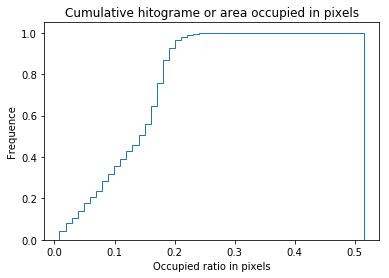

In [9]:
n, bins, patches = plt.hist(SurveyRatio[~np.isnan(SurveyRatio)], 50, histtype='step', cumulative=1, normed=True)
plt.xlabel('Occupied ratio in pixels')
plt.ylabel('Frequence')
plt.title('Cumulative hitograme or area occupied in pixels')


In [212]:
CoverThreshold = 0.18
print('Nombre de Pixels Totale : {0:d}\nNombre de Pixels conservé: {1:d}'.format(np.sum(~np.isnan(SurveyRatio)),np.sum(SurveyRatio>CoverThreshold))) 

Nombre de Pixels Totale : 2417
Nombre de Pixels conservé: 607


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in greater



In [213]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyIndex = np.full(ClassifIndex.shape, False, dtype=np.bool_)

rows, cols = np.where(SurveyRatio>CoverThreshold)
for i, j  in zip(rows,cols):
    Points = np.asarray(DictoPos[(i, j)])
    SurveyValues[i, j] = mgp.InterpPixDepth(Points, DictoDeph[i, j], modes=['nearest'], PlotArg=False)[0]
    SurveyIndex[i, j] = True

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in greater



## Load Optical Data
### WARNING: Poe special case -> to avoid bigger backup size, data need to be resize at Rasters dimension

In [214]:
# Load Data at reduce backup size
npzfile = np.load('../../../Poe/CompressedData/SRXData.npz')
Xc = npzfile['Ratios'] # Optical data at croped shape (reduce backup size)
RatiosKeys = npzfile['Keys'] # Keys defining order of recorded ratios 

# Creation of arrays at Raster Size
X = np.full((RasterHeight, RasterWidth, Xc.shape[2]), np.nan) # Final array of optical data at Raster size 
ValidMap = np.full((RasterHeight, RasterWidth), False) # Map of area of Interest -> cropped area reducing backup size

# Translation of the data at the suitable dimension
X[5000:,0:8500,:] = Xc[:,:,:]
ValidMap[5000:,0:8500] = True
del Xc

# Useless here...
ToclassifyIndex = np.logical_and(ValidMap,ClassifIndex)
X.shape

(10980, 10980, 10)

## Special case in Poe, Area of interest for specific calibration manually created

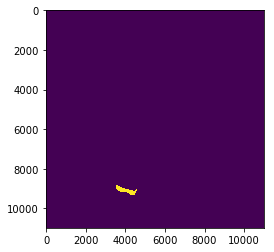

In [215]:
ShapeFolder = '../../../Poe/Shapes/'
RoiPathName = 'SheratonLagoon.shp'

ResctictedLagoon = mgp.create_mask_from_vector(ShapeFolder + RoiPathName,  RasterHeight, RasterWidth, GT_ds, proj, target_value=1, format=gdal.GDT_Byte)
ResctictedLagoon = ResctictedLagoon.GetRasterBand(1).ReadAsArray().astype(bool)
plt.imshow(ResctictedLagoon)

## Visual check !

Nombre de pixel comportant une mesure immergées: 484


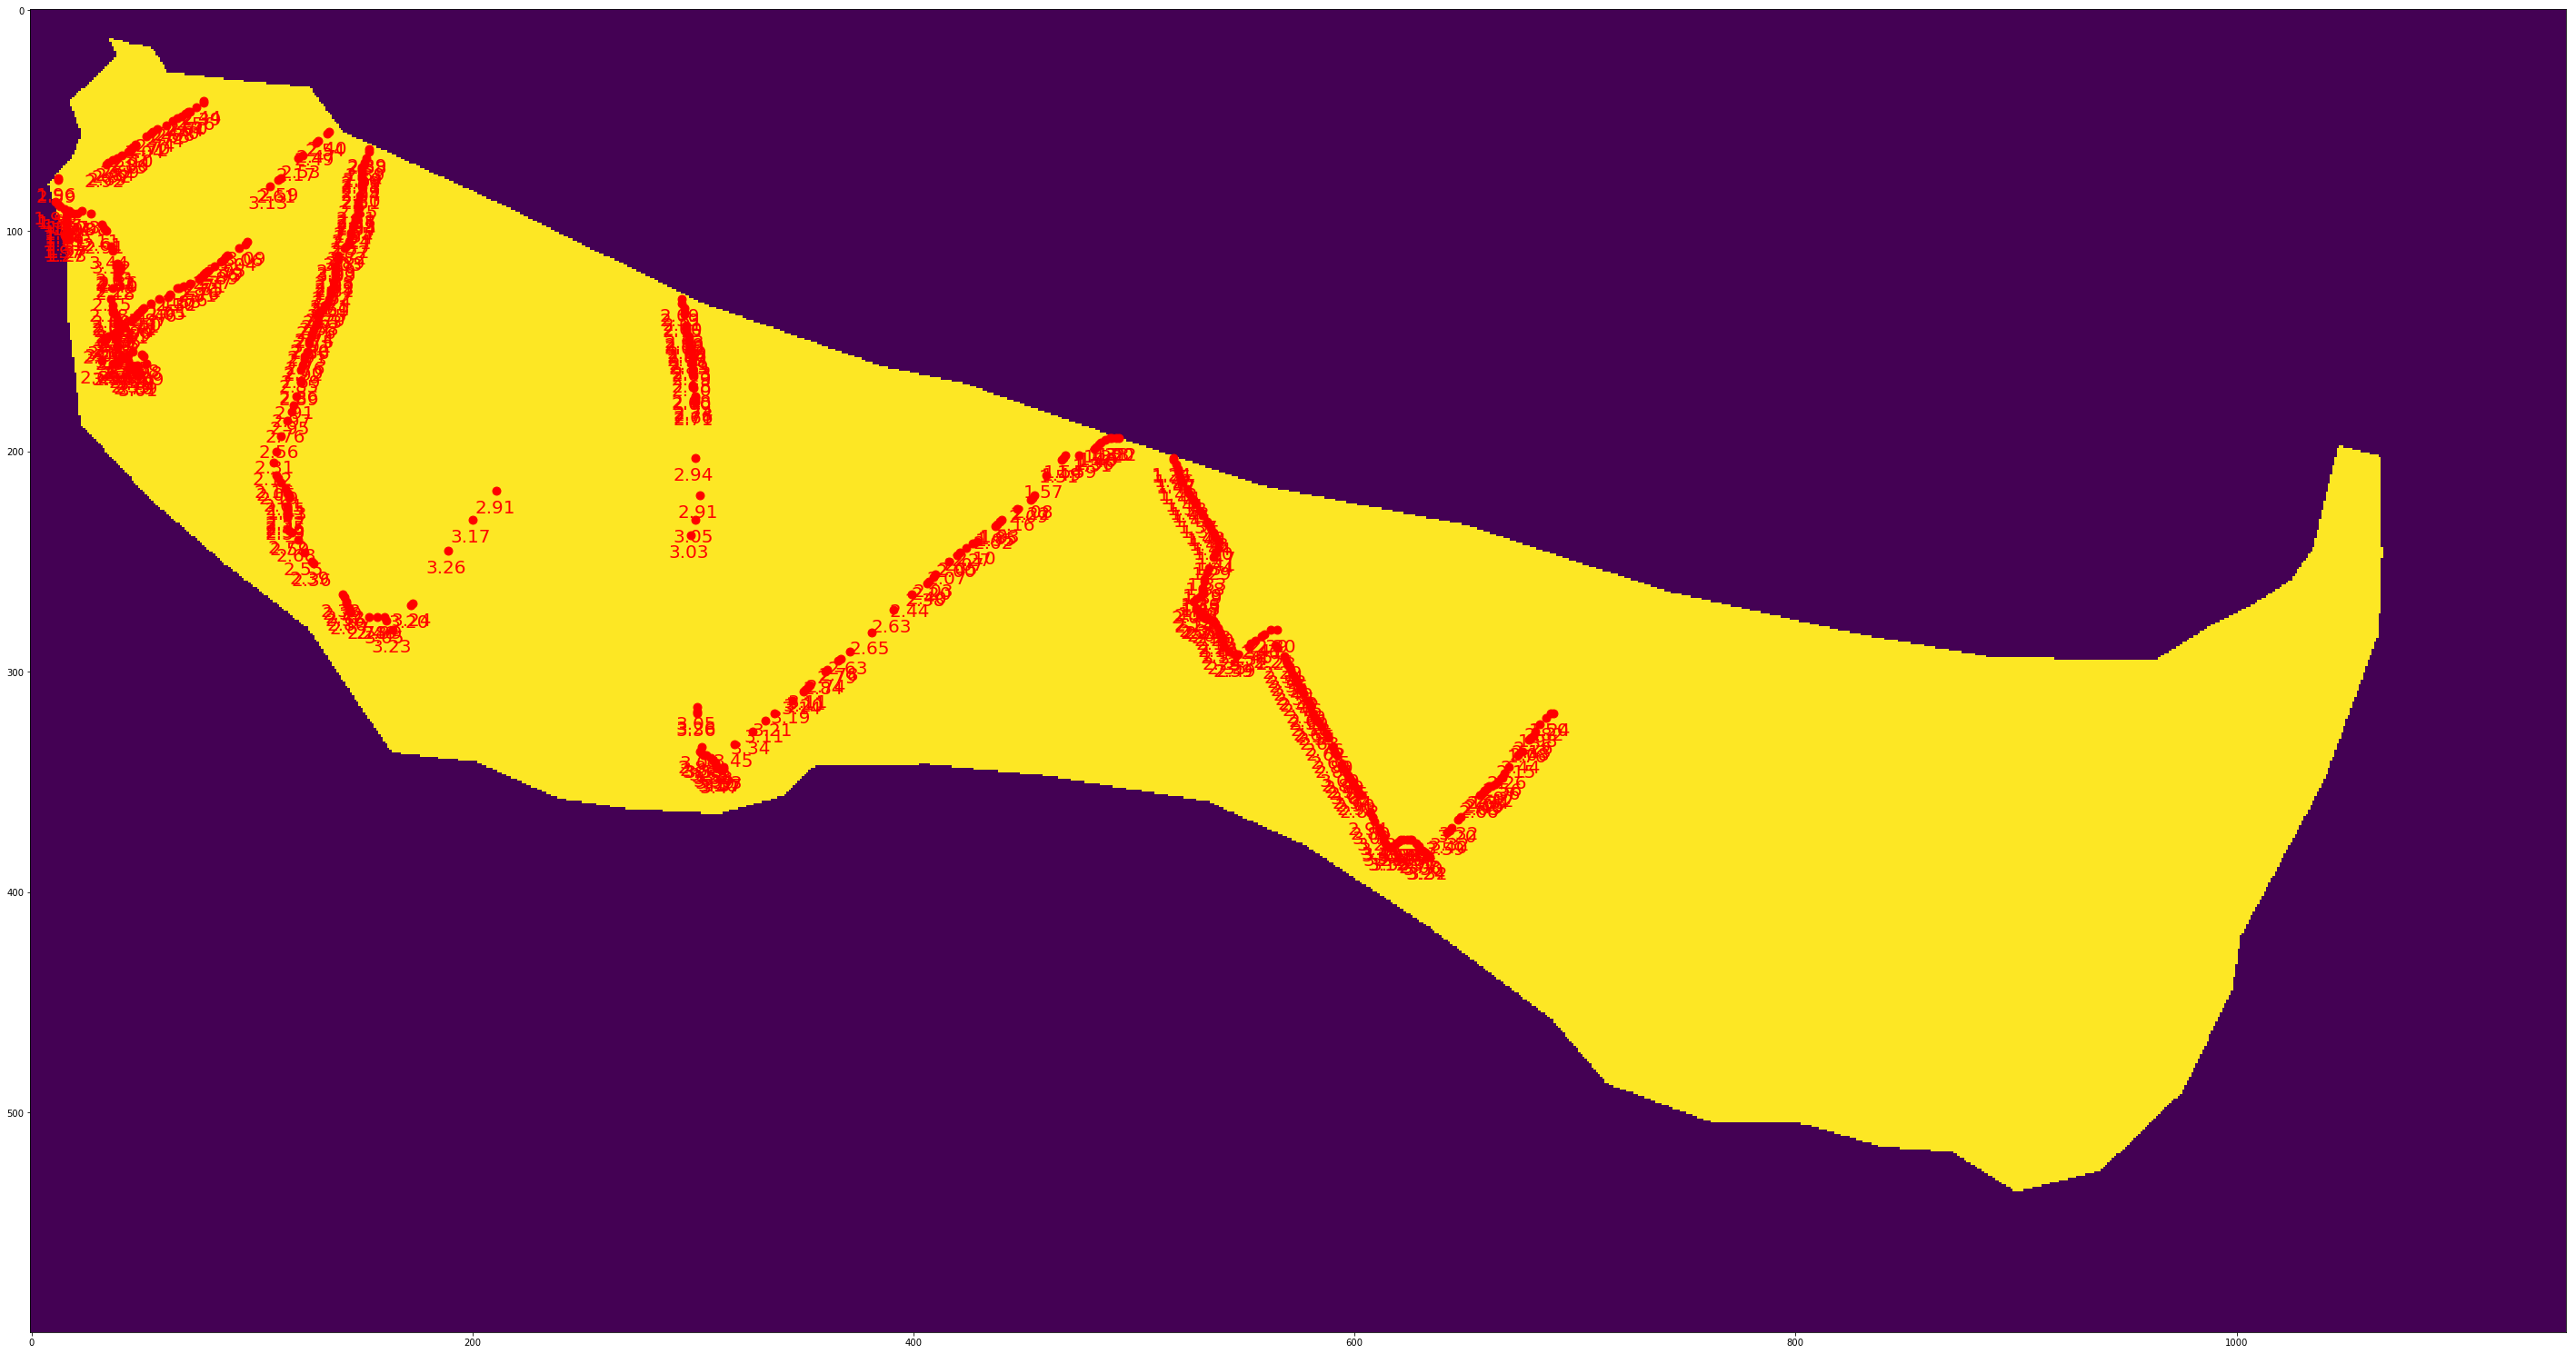

In [216]:
# Manual cropping for better visual rendering
ScatterIndex = np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650])
CroppedDepth = SurveyValues[8800:9400,3500:4650] # Average deph of pixels contained in the visual cropped

# Scatter coordinates and image in rendered dimension
x,y = np.where(ScatterIndex)
Im = ResctictedLagoon[8800:9400,3500:4650]

# Plot
fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(Im)
plt.scatter(y,x,s=80, c='r')
for i in range(len(x)):
    ax.annotate('{0:.2f}'.format(CroppedDepth[ScatterIndex][i]), (y[i]-10,x[i]+10), color='red', size=20)
print("Nombre de pixel comportant une mesure immergées:",len(x))

## Creation of calibration dataset

In [217]:
assert X.shape[:2]==SurveyValues.shape
ind = ResctictedLagoon * (SurveyIndex>0) # Index of calibration data
Data_x = X[ind,:] # model optical descriptors
Data_y = SurveyValues[ind].reshape(np.sum(ind),) # model target depth

## release memory

In [218]:
del X

## exploratory statistics

['Red' 'ExtraRed'] correlation :  0.48663346216
['Green' 'ExtraRed'] correlation :  0.854491037771
['Blue' 'ExtraRed'] correlation :  0.845338169525
['ExtraBlue' 'ExtraRed'] correlation :  0.85041523711
['Green' 'Red'] correlation :  0.923733332093
['Blue' 'Red'] correlation :  0.922645077217
['ExtraBlue' 'Red'] correlation :  0.887672518032
['Blue' 'Green'] correlation :  0.514905970449
['ExtraBlue' 'Green'] correlation :  0.270767786183
['ExtraBlue' 'Blue'] correlation :  0.0427487514233


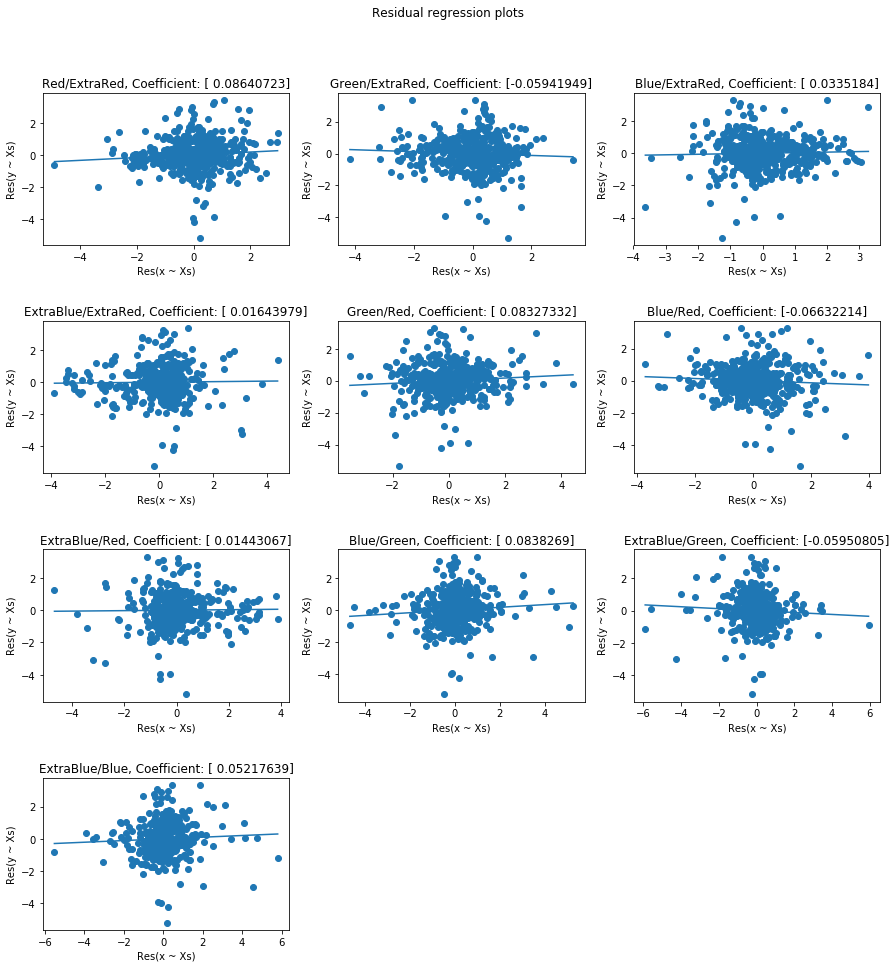

In [219]:
for i in range(Data_x.shape[1]):
    print(str(RatiosKeys[i]),'correlation : ',np.corrcoef(Data_x[:,i],Data_y)[0,1])
    print("="*10)
mgp.plot_ResRegPlots(Data_x, Data_y, Scale=True, SetTitles=True, Titles=[str(i)+'/'+str(j) for i,j in RatiosKeys])

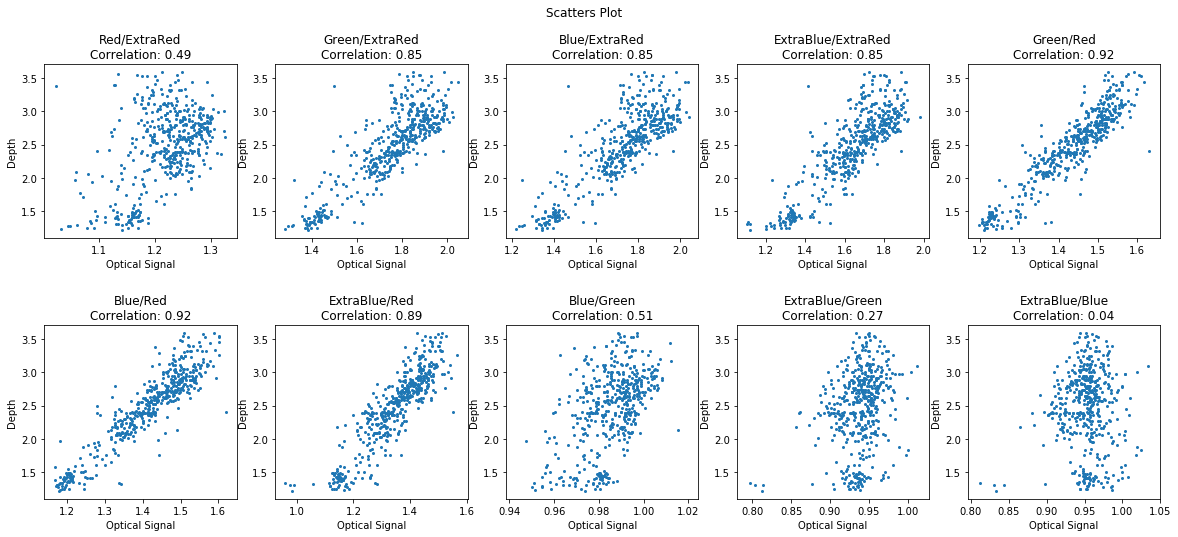

In [220]:
fig, axes = plt.subplots(2,5, figsize=(20, 8))
fig.suptitle('Scatters Plot')
fig.subplots_adjust(hspace=.5, top=.88)
for i, ax in enumerate(fig.axes):
    ax.scatter(Data_x[:,i],Data_y, s=4)
    ax.set_title(RatiosKeys[i][0]+'/'+RatiosKeys[i][1]+'\nCorrelation: {0:0.2f}'.format(np.corrcoef(Data_x[:,i],Data_y)[0,1]))
    ax.set_ylabel('Depth')
    ax.set_xlabel('Optical Signal')

In [221]:
x = Data_x
y = Data_y

# Simple linear Regression (Stumpf)

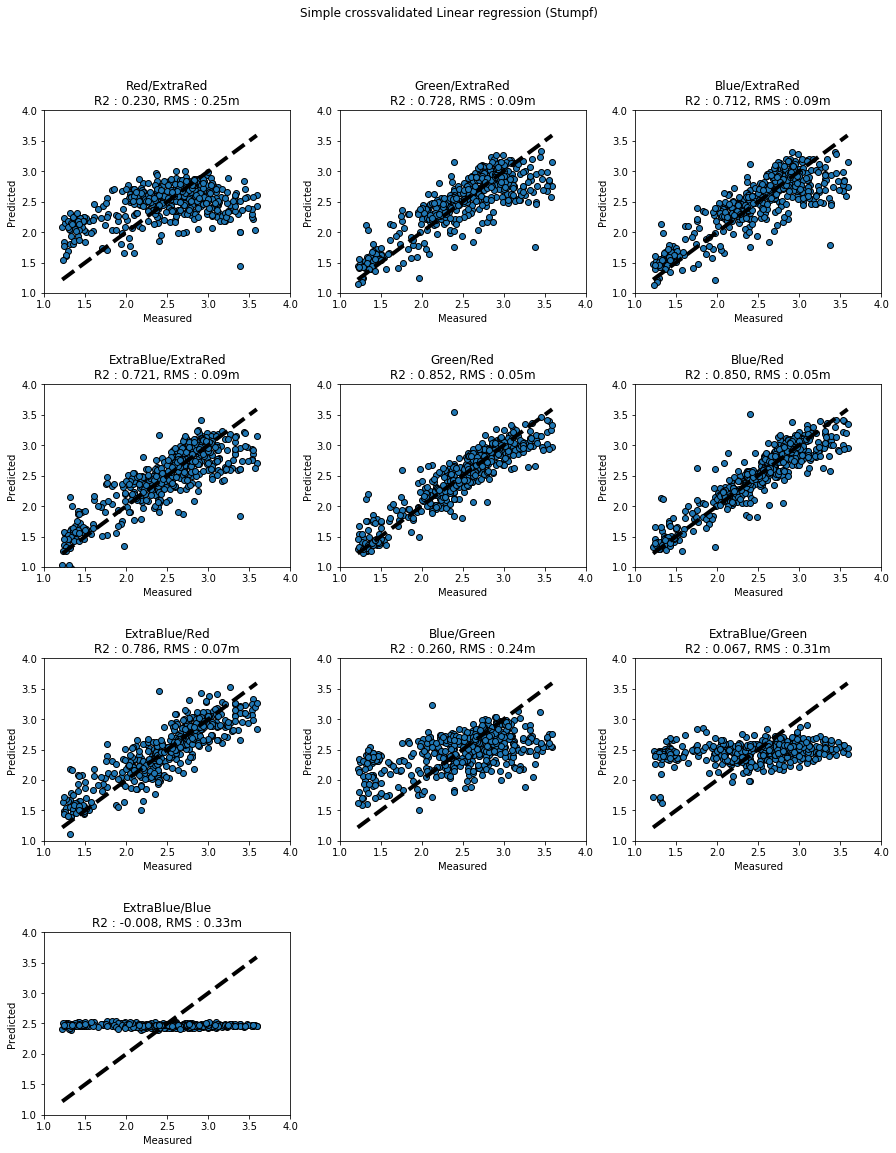

In [222]:
plotsPerRows = 3
fig , axes = plt.subplots(int(np.ceil(x.shape[1]/plotsPerRows)),plotsPerRows, figsize=(15,18))
fig.suptitle('Simple crossvalidated Linear regression (Stumpf)')
fig.subplots_adjust(hspace=.5, top=.9)
Outputs = []

for i, ax in enumerate(fig.axes):
    if i >= x.shape[1]:
        ax.set_visible(False)
        continue
    Outputs.append(mgp.my_LeaveOneOutCV(linear_model.LinearRegression(), x[:,i].reshape(-1,1), y, ax=ax, SetTitles= True, Titles=RatiosKeys[i][0]+'/'+RatiosKeys[i][1]))
    ax.set_xlim(1,4)
    ax.set_ylim(1,4)
plt.show()

# Simple Multi-linear Regression (Stumpf)

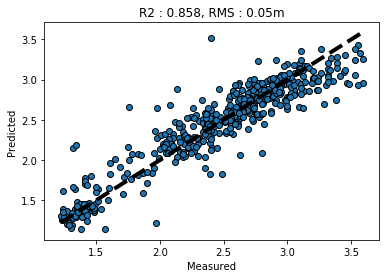

In [223]:
Outputs = []

Outputs.append(mgp.my_LeaveOneOutCV(linear_model.LinearRegression(), x, y,))


# Multi-linear : Ridge Regression

Best RMS : 0.046 with alpha = 9.01E-04
Best R2 : 0.859 with alpha = 9.01E-04



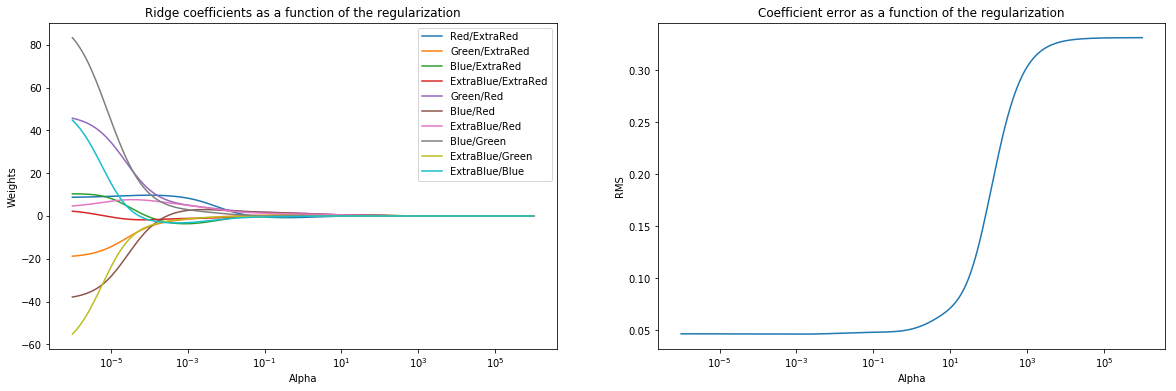

In [224]:

alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = linear_model.Ridge(alpha=a)
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))

coefs = [Outputs[i][1]['Coefs'] for i in range(len(alphas))]
RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]

# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Ridge coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )
ax[1].plot(alphas, RMS)
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')

fig.show

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

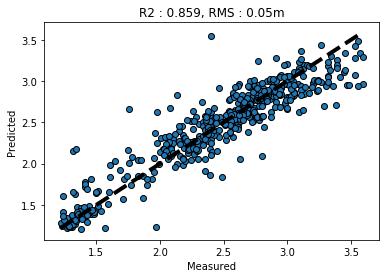

In [225]:
a = alphas[np.argmin(RMS)]
lr = linear_model.Ridge(alpha=a)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

# Multi-linear : Lasso Regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



Best RMS : 0.046 with alpha = exp(-5.88)
Best R2 : 0.859 with alpha = exp(-5.88)



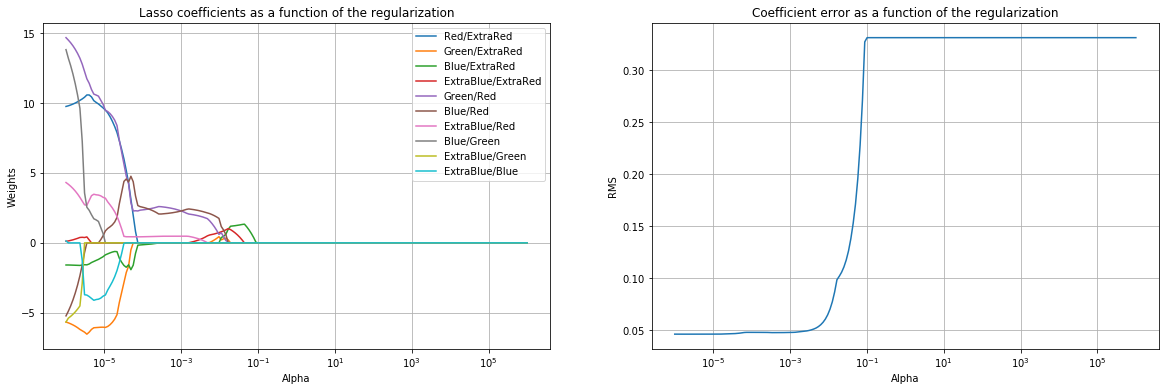

In [226]:

alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = linear_model.Lasso(alpha=a, max_iter=5000)
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))

coefs = [Outputs[i][1]['Coefs'] for i in range(len(alphas))]
RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]

# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Lasso coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )
ax[0].grid()
ax[1].plot(alphas, RMS)
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')
ax[1].grid()

fig.show

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



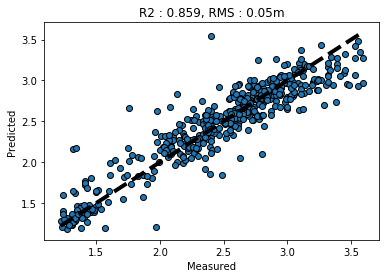

In [227]:
a = alphas[np.argmin(RMS)]
lr = linear_model.Lasso(alpha=a, max_iter=10000)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

# Huber Regression

In [208]:
SizeE, SizeA = 40, 200
epsilons = np.linspace(1.01, 1.40, SizeE)
alphas = np.logspace(-7, 5, SizeA)
RMS = np.full((SizeE,SizeA), np.nan, np.float)
R2_scores = np.full((SizeE,SizeA), np.nan, np.float)
coefs = np.full((SizeE,SizeA,x.shape[1]), np.nan, np.float)

Outputs = []

for ie, e in enumerate(epsilons):
    Outputs.append([])
    for ia, a in enumerate(alphas):
        lr = linear_model.HuberRegressor(alpha=a, epsilon=e, fit_intercept=True, max_iter=1000)
        Outputs[ie].append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))
    RMS[ie,:] = np.asarray([Outputs[ie][i][1]['RMS'] for i in range(len(alphas))])
    R2_scores[ie,:] = np.asarray([Outputs[ie][i][1]['R2_score'] for i in range(len(alphas))])
    coefs[ie,:,:] = np.asarray([Outputs[ie][i][1]['Coefs'] for i in range(len(alphas))])

bestE_R2, bestA_R2 = np.where(np.max(R2_scores)==R2_scores)
bestE_RMS, bestA_RMS = np.where(np.min(RMS)==RMS)

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f}), epsilons = {2:1.2f}\nBest R2 : {3:.3f} with alpha = exp({4:1.2f}), epsilons = {5:1.2f}\n'.format(
RMS[bestE_RMS, bestA_RMS][0], np.log10(alphas[bestA_RMS][0]), epsilons[bestE_RMS][0], 
R2_scores[bestE_R2, bestA_R2][0], np.log10(alphas[bestA_R2][0]), epsilons[bestE_R2][0]))

Best RMS : 0.053 with alpha = exp(-4.47), epsilons = 1.01
Best R2 : 0.854 with alpha = exp(-4.47), epsilons = 1.01



<bound method Figure.show of <matplotlib.figure.Figure object at 0x0000000143D14470>>

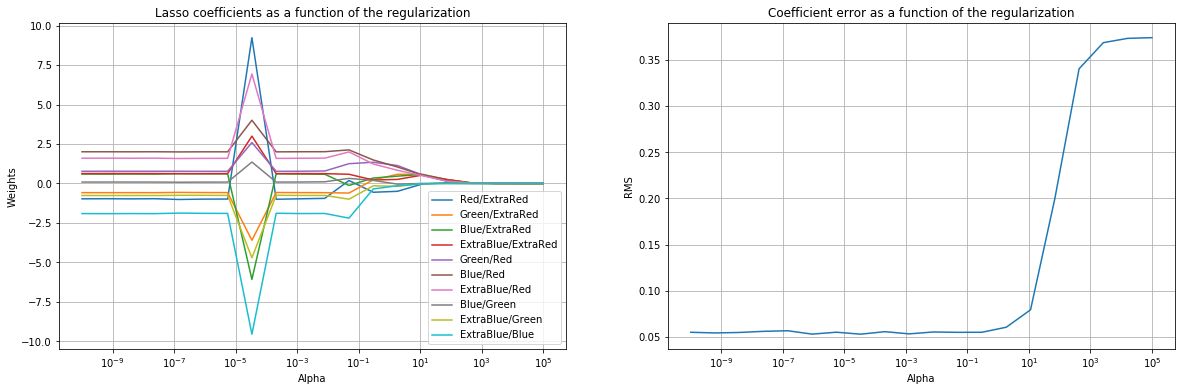

In [209]:
# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, [coefs[bestE_R2,i,:].reshape(-1,) for i in range(len(alphas))])
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Lasso coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )
ax[0].grid()
ax[1].plot(alphas, RMS[bestE_R2,:].T)
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')
ax[1].grid()

fig.show

In [210]:
from plotly import tools
Surf1 = [go.Surface(z=RMS)]
Surf1 = [go.Surface(z=R2_scores)]
scene = dict(
            xaxis = dict(
                ticktext= ['exp({0:1.0f})'.format(np.log10(a)) for a in alphas][0::20],
                tickvals= [i for i in range(len(alphas))][0::20],
                title='Alphas',
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            yaxis = dict(
                ticktext= ['{0:.2f}'.format(e) for e in epsilons][0::5],
                tickvals= [i for i in range(len(epsilons))][0::5],
                title='Epsilons',
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            zaxis = dict(
                title='RMS',
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
        )

fig = tools.make_subplots(rows=1, cols=2,specs=[[{'is_3d': True}, {'is_3d': True}]])
# adding surfaces to subplots.
fig.append_trace(dict(type='surface',z=RMS, colorscale='Viridis',
                      scene='scene1', showscale=True), 1, 1)
fig.append_trace(dict(type='surface',z=R2_scores, colorscale='RdBu',
                      scene='scene2', showscale=True), 1, 2)

fig['layout'].update(title='subplots with different colorscales',
                     height=400, width=800)
fig['layout']['scene1'].update(scene)
fig['layout']['scene2'].update(scene)

plotly.offline.iplot(fig, filename='elevations-3d-surface')

This is the format of your plot grid:
[ (1,1) scene1 ]  [ (1,2) scene2 ]



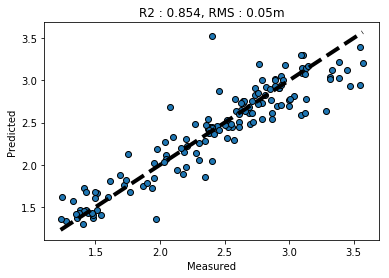

In [211]:
lr = linear_model.HuberRegressor(alpha=alphas[bestA_R2], epsilon=epsilons[bestE_R2], max_iter=10000)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

In [ ]:
lr = linear_model.LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#predicted = cross_val_predict(lr, x, y, cv=len(y))
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

# Cross Validated RANSAC

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(x)
predicted = np.full(y.shape,np.nan, np.float)
inlierMat = np.full((y.shape[0], 1, len(y)),np.nan, np.float)
#lr = linear_model.RANSACRegressor(min_samples=0.9, max_trials=100000, residual_threshold=0.4,stop_probability=0.999)
lr = linear_model.RANSACRegressor(min_samples=0.5, residual_threshold=0.2)
counterCheck = 0


for train_index, test_index in loo.split(x):
    lr.fit(x[train_index], y[train_index])
    predicted[test_index] = lr.predict(x[test_index])
    inlierMat[train_index, 0, counterCheck] = lr.inlier_mask_
    counterCheck = counterCheck + 1
    
col = np.nansum(inlierMat, axis=2)
fig, ax = plt.subplots(figsize=(15,15))
im = ax.scatter(y, predicted,c=col, cmap='jet')
plt.colorbar(im)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

In [ ]:
xIm,yIm = np.where(np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0))
y = SurveyValues[ind].reshape(np.sum(ind),)
plotInd = (col>5).reshape(len(y),)
indIm = ResctictedLagoon[8800:9400,3500:4650]
fig = plt.figure(figsize=(50,50))
plt.imshow(indIm)
plt.scatter(yIm[plotInd],xIm[plotInd],s=80, c='b', label='Inliers')
plt.scatter(yIm[~plotInd],xIm[~plotInd],s=80, c='r', label='Outliers')
plt.legend()
print("Nombre de point extreme :",np.sum(~plotInd))

# RANSAC Whithout cross validation

In [ ]:
lr = linear_model.RANSACRegressor(min_samples=0.9, max_trials=100000, residual_threshold=0.4,stop_probability=0.999)


# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.scatter(y, predicted, c=lr.inlier_mask_, s=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

In [ ]:
xIm,yIm = np.where(np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0))
y = SurveyValues[ind].reshape(np.sum(ind),)
plotInd = (col>5).reshape(len(y),)
indIm = ResctictedLagoon[8800:9400,3500:4650]
fig = plt.figure(figsize=(50,50))
plt.imshow(indIm)
plt.scatter(yIm[plotInd],xIm[plotInd],s=80, c='b', label='Inliers')
plt.scatter(yIm[~plotInd],xIm[~plotInd],s=80, c='r', label='Outliers')
plt.legend()
print("Nombre de point extreme :",np.sum(~plotInd))

In [ ]:
testImage = testImage[8800:9400,3500:4650]**0.4

In [ ]:
xIm,yIm = np.where(np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0))
fig = plt.figure(figsize=(50,50))
plt.imshow(testImage)
plt.scatter(yIm,xIm,s=80, c='r')